<div style="color:white;
           display:fill;
           border-radius:15px;
           background-color:black;
           font-size:140%;
           font-family:#afd511;
           letter-spacing:0.5px">

<h3 style="padding: 20px; color:white; text-align:center"><b> Quora question pair similarity check </b></h3>
</div>

# 1. Dataset Sources and Description:

This was a competition hosted by quora on kaggle in 2016. The dataset for this competition can be found here.

    The data is stored in a file named Train.csv.
    The Train.csv file contains a total of 5 columns, namely qid1, qid2, question1, question2, and is_duplicate.
    The size of the Train.csv file is approximately 60MB.
    The total number of rows in the Train.csv file is 404,290.
    
The given dataset had the following structure:

    id: The ID assigned to each question pair in the training set.
    qid1: ID of the first question in the pair to be compared for duplicacy.
    qid2: ID of the second question in the pair to be compared for duplicacy.
    question1: Description of the first question in the pair.
    question2: Description of the second question in the pair.
    is_duplicate: A flag indicating whether the questions in the pair are duplicates of each other or no
    

<h3> ~> Data source </h3>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

# 2. Mapping to a Machine Learning Problem:

<h3> ~> Problems indentification </h3>

This is a binary classification problem where we need to predict whether a pair of questions are semantically similar or not.

# 3 Import libraries

In [1]:
!pip install --upgrame pandas


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --upgrame


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize,sent_tokenize,RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from collections import Counter
from Levenshtein import distance
from fuzzywuzzy import fuzz
from difflib import SequenceMatcher


from bs4 import BeautifulSoup
import re
from tqdm import tqdm
import time
import inflect
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /home/sujon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sujon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
df=pd.read_csv('quora.csv')

In [5]:
# df=df[:10290]

In [6]:
df.shape

(404290, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [8]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [9]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [10]:
df.tail(4)

,id,qid1,qid2,question1,question2,is_duplicate
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


# 4. Exploratory Data Analysis (EDA):

<h3> ~> Distribution data plots </h3>

<Axes: xlabel='is_duplicate'>

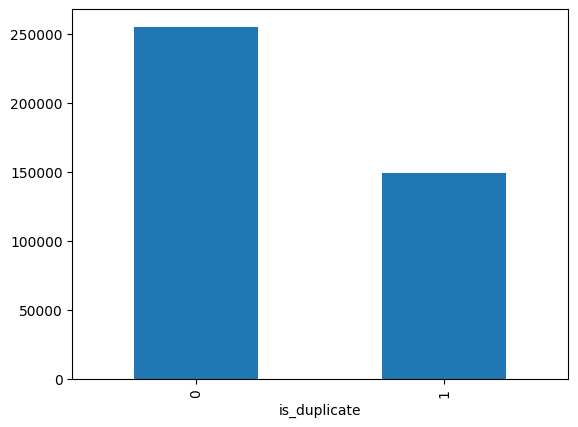

In [11]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [12]:
print('Total number of pair questions:',len(df))

Total number of pair questions: 404290


In [13]:
print('Question pair are not similar(is_duplicate=0)):',(df['is_duplicate']))

Question pair are not similar(is_duplicate=0)): 0         0
1         0
2         0
3         0
4         0
         ..
404285    0
404286    1
404287    0
404288    0
404289    0
Name: is_duplicate, Length: 404290, dtype: int64


In [14]:
dvc=df.is_duplicate.value_counts()
dvc

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [15]:
print('Question pair are not similar(is_duplicate=0): {}%'.format(round((df['is_duplicate']==0).mean()*100,2)))
print('Question pair are similar(is_duplicate=1): {}%'.format(round((df['is_duplicate']==1).mean()*100,2)))

Question pair are not similar(is_duplicate=0): 63.08%
Question pair are similar(is_duplicate=1): 36.92%


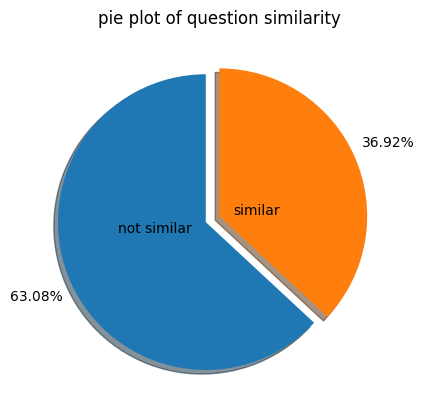

In [16]:
plt.title('pie plot of question similarity')
label=['not similar','similar']
explode = (0.1, 0)
plt.pie(dvc,labels=label,autopct='%1.2f%%',startangle=90,
         pctdistance=1.25, labeldistance=.1,  shadow=True,explode=explode)
plt.show()

<h3> ~> Number of unique questions </h3>

In [17]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

unique_questions=len(np.unique(qids))
qs_morethen_onetime=np.sum(df['qid1'].value_counts()> 1 )
print('Total Unique Question: {}'.format(unique_questions))
print('Total question more then onetime: {}'.format(qs_morethen_onetime,))
print('Total question more then onetime(parcentage): {} %'.format(round(qs_morethen_onetime/unique_questions*100,2)))
print('Max number of times a single question is repeated: {}'.format(max(qids.value_counts()))) 

Total Unique Question: 537933
Total question more then onetime: 54073
Total question more then onetime(parcentage): 10.05 %
Max number of times a single question is repeated: 157


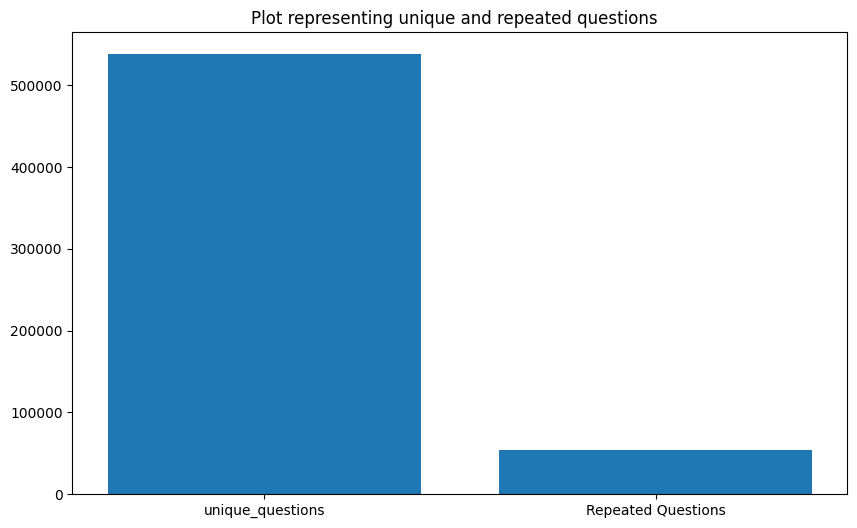

In [18]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_questions , qs_morethen_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
plt.bar(x,y)
plt.show()

<h3> ~> Checking for duplicate question pair </h3>

In [19]:
pair_qs_duplicate = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions",(pair_qs_duplicate).shape[0] - df.shape[0])

Number of duplicate questions 0


In [20]:
pair_question = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count()


<h3> ~> frequecny of questions </h3>

Maximum number of times a single question is repeated: 157



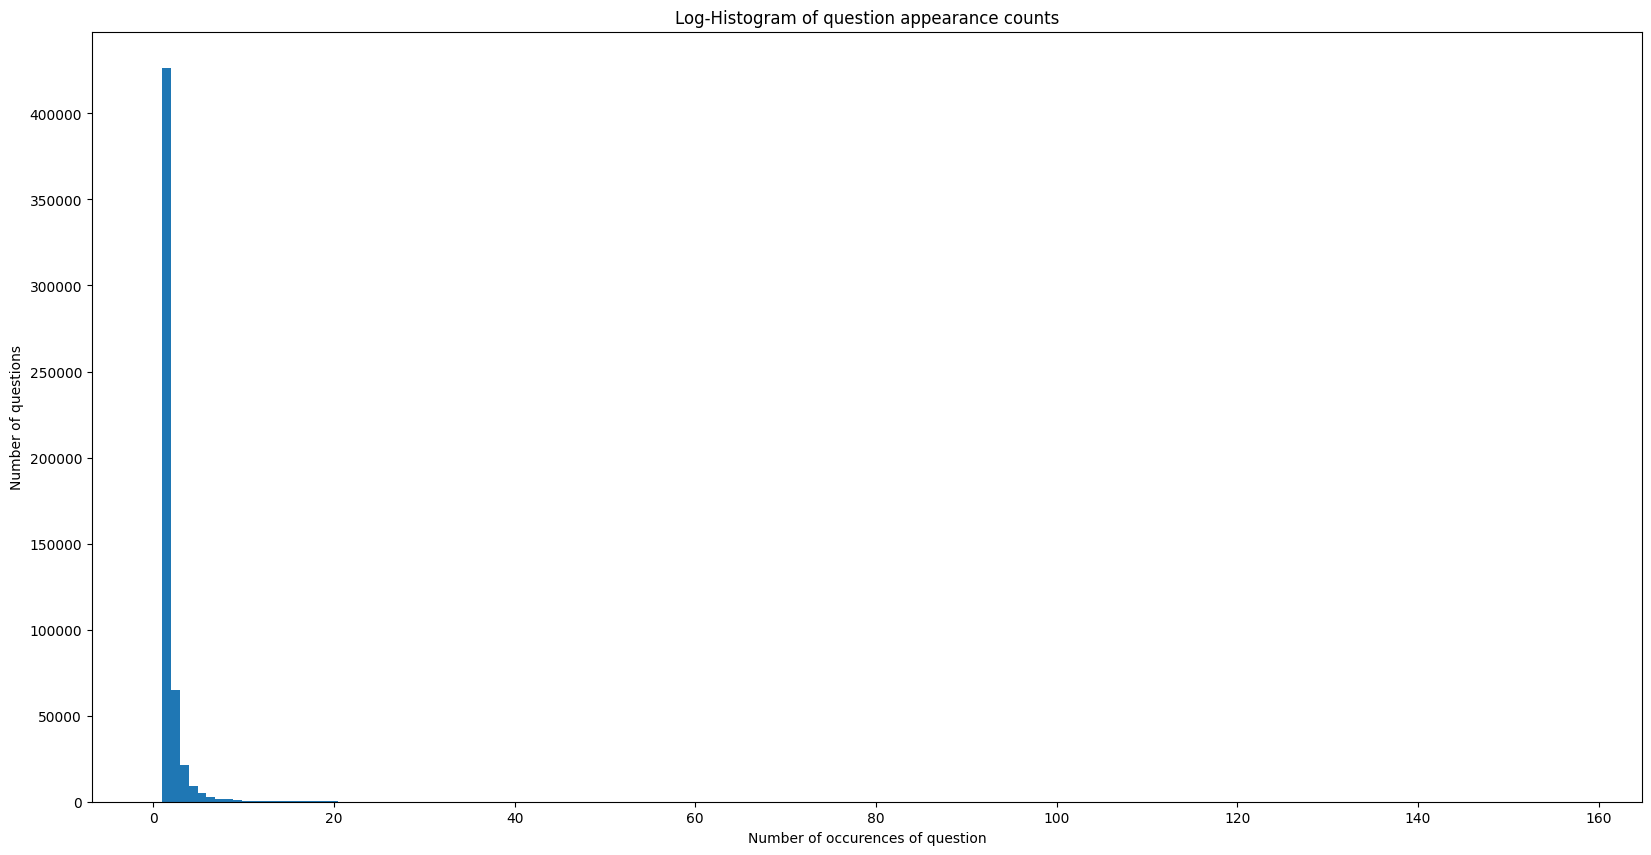

In [21]:
plt.figure(figsize=(20,10))
plt.title('Frequency of questions')
plt.hist(qids.value_counts(), bins=160)
plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 
plt.show()

<h3> ~> Checking Null Values</h3>

In [22]:
nan_rows = df[df.isnull().any(axis=1)]
print(nan_rows) 

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [23]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(axis=1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


# 5. Basic feature extraction of the extracted feature

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [24]:
class FeatureEngineering:
    def __init__(self, dataframe):
        self.df = dataframe
        self.calculate_frequency_features()
        self.calculate_length_and_word_features()

    def calculate_frequency_features(self):
        self.df['freq_qid1'] = self.df.groupby('qid1')['qid1'].transform('count')
        self.df['freq_qid2'] = self.df.groupby('qid2')['qid2'].transform('count')
        self.df['frq_q1+q2'] = self.df['freq_qid1'] + self.df['freq_qid2']
        self.df['frq_q1-q2'] = abs(self.df['freq_qid1'] - self.df['freq_qid2'])

    def calculate_length_and_word_features(self):
        self.df['q1len'] = self.df['question1'].str.len()
        self.df['q2len'] = self.df['question2'].str.len()
        self.df['q1_n_words'] = self.df['question1'].apply(lambda row: len(row.split(" ")) if pd.notna(row) else 0)
        self.df['q2_n_words'] = self.df['question2'].apply(lambda row: len(row.split(" ")) if pd.notna(row) else 0)
        self.df['word_common'] = self.df.apply(self.word_common, axis=1)
        self.df['word_share'] = self.df.apply(self.word_share, axis=1)
        self.df['word_total'] = self.df.apply(self.word_total, axis=1)

    @staticmethod
    def word_common(row):
        if pd.notna(row['question1']) and pd.notna(row['question2']):
            w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
            w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))
            return 1.0 * len(w1 & w2)
        else:
            return 0.0

    @staticmethod
    def word_share(row):
        if pd.notna(row['question1']) and pd.notna(row['question2']):
            w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
            w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))
            return 1.0 * (len(w1 & w2) / len(w1) + len(w2))
        else:
            return 0.0

    @staticmethod
    def word_total(row):
        if pd.notna(row['question1']) and pd.notna(row['question2']):
            w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
            w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))
            return 1.0 * (len(w1) + len(w2))
        else:
            return 0.0

feature_engineering_instance = FeatureEngineering(df)


In [25]:
df

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,frq_q1+q2,frq_q1-q2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_share,word_total
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,2,0,66,57,14,12,10.0,11.833333,23.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,5,3,51,88,8,13,4.0,12.500000,20.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,2,0,73,59,14,10,4.0,10.285714,24.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,2,0,50,65,11,9,0.0,9.000000,19.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,4,2,76,39,13,7,2.0,7.153846,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,2,2,4,0,85,79,14,13,11.0,12.846154,25.0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,12,1,13,11,41,42,8,9,5.0,8.625000,16.0
404287,404287,537928,537929,What is one coin?,What's this coin?,0,1,1,2,0,17,17,4,3,1.0,3.250000,7.0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,1,1,2,0,94,127,17,25,1.0,23.058824,40.0


In [26]:
df['frq_q1-q2'].value_counts()

0      208066
1       88907
2       36694
3       18966
4       11327
        ...  
109         1
59          1
107         1
72          1
93          1
Name: frq_q1-q2, Length: 101, dtype: int64

<h3> ~> Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [27]:
print("Minimum length of the questions in question1 :",min(df['q1_n_words']))
print("Maximum length of the questions in question1 :",max(df['q1_n_words']))

print("**************************************************")

print("Minimum length of the questions in question2 :",min(df['q2_n_words']))
print("Maximum length of the questions in question2 :",max(df['q2_n_words']))

print("**************************************************")

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

print("**************************************************")


Minimum length of the questions in question1 : 1
Maximum length of the questions in question1 : 125
**************************************************
Minimum length of the questions in question2 : 1
Maximum length of the questions in question2 : 237
**************************************************
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24
**************************************************


<h3> ~> word_share </h3>

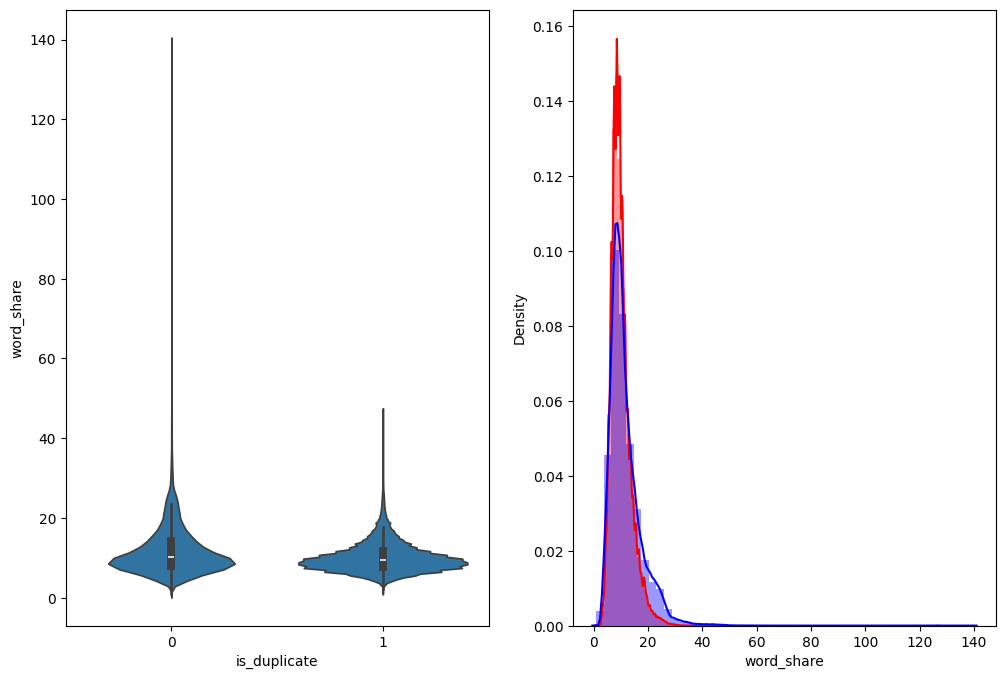

In [28]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['word_share'][0:],label='1',color='red')
sns.distplot(df[df['is_duplicate']==0.0]['word_share'][0:],label='0',color='blue')

plt.show()

<h3> ~> total_word </h3>

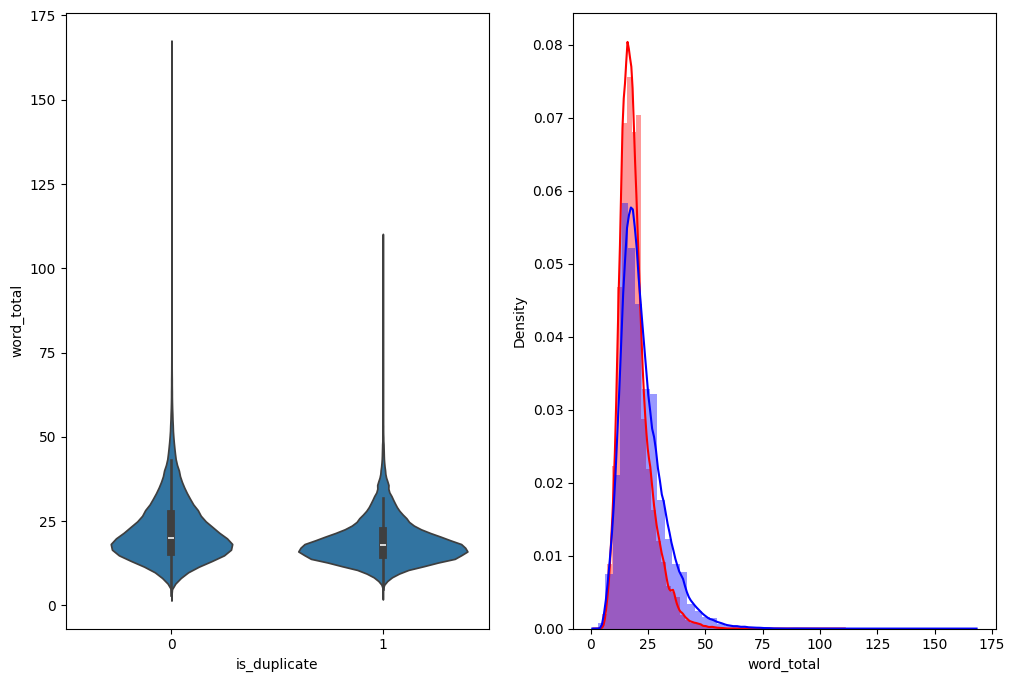

In [29]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x= 'is_duplicate',y='word_total',data=df[0:])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['word_total'][0:],label='1',color='red')
sns.distplot(df[df['is_duplicate']==0.0]['word_total'][0:],label='1',color='blue')

plt.show()

<h3> ~> common_word </h3>

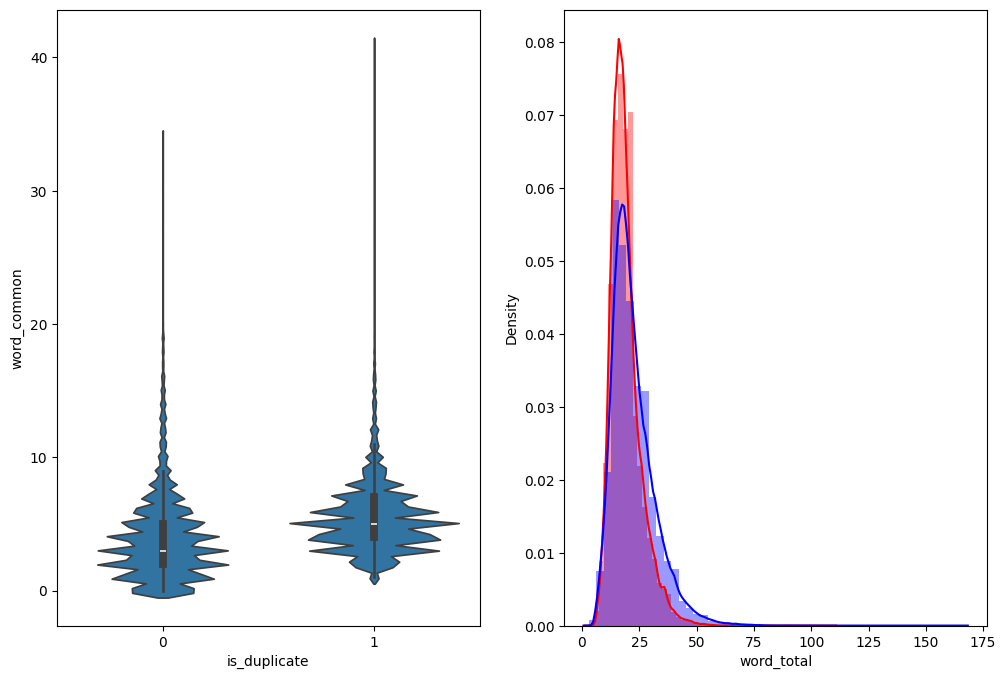

In [30]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x= 'is_duplicate',y='word_common',data=df[0:])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['word_total'][0:],label='1',color='red')
sns.distplot(df[df['is_duplicate']==0.0]['word_total'][0:],label='1',color='blue')

plt.show()

In [31]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'frq_q1+q2', 'frq_q1-q2', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_common', 'word_share', 'word_total'],
      dtype='object')

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

<h3> ~> EDA: Advanced Feature Extraction. </h3>

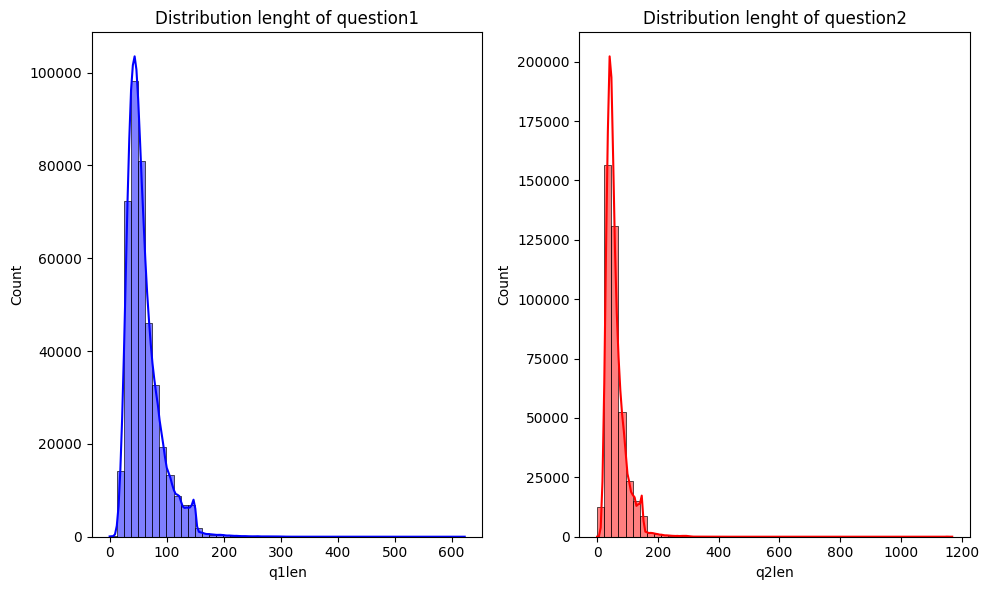

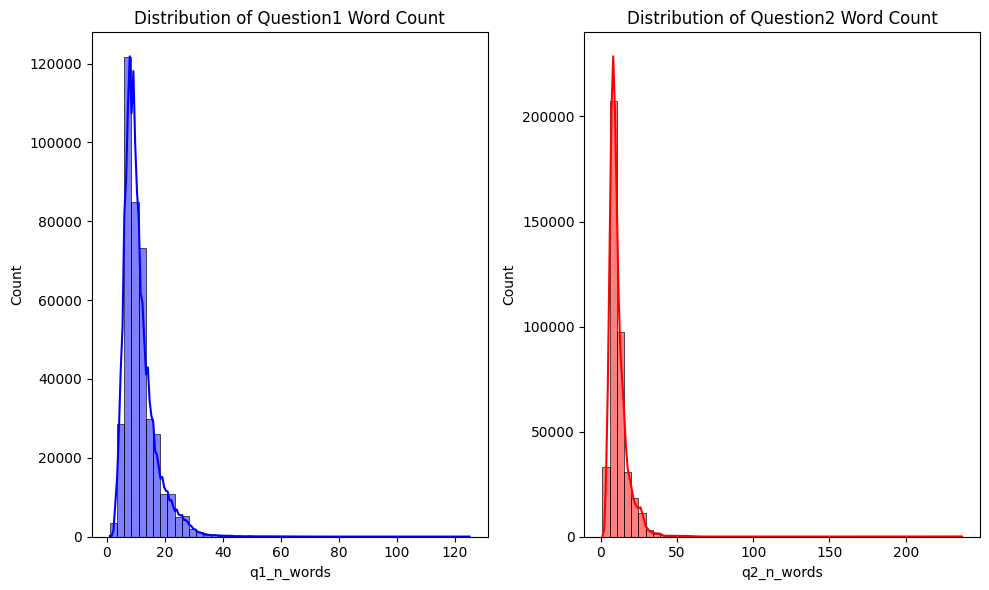

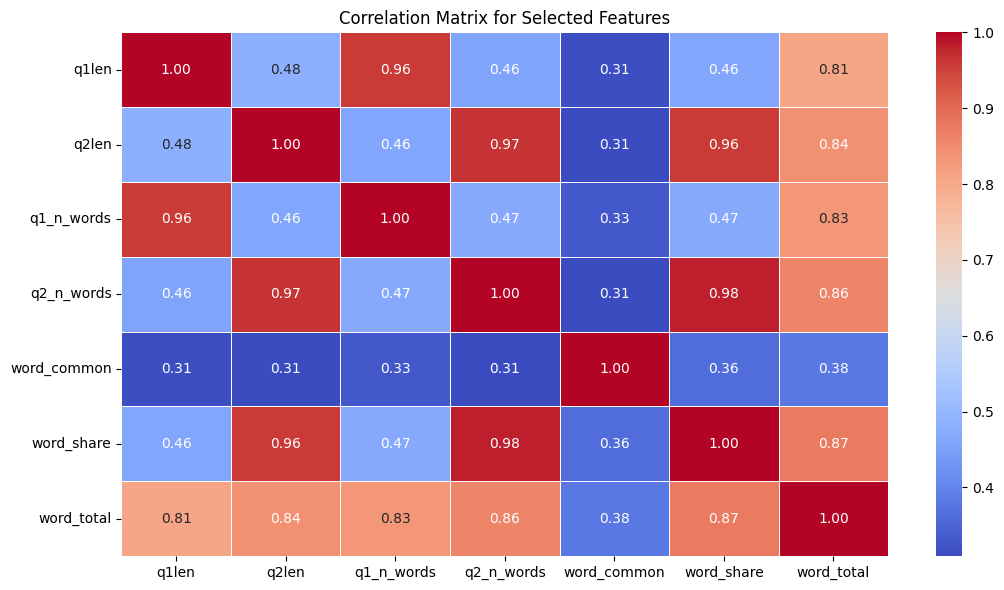

In [32]:
class advancedFeatureExtractionEDA:
    def __init__(self,DataFrame):
        self.df=DataFrame
        self.plot_distribution()
        self.plot_correlation()
        
    def plot_distribution(self):
        
        plt.figure(figsize=(10,6))
        plt.subplot(1,2,1)
        sns.histplot(self.df['q1len'],kde=True,bins=50,color='blue')
        plt.title('Distribution lenght of question1')
        
        plt.subplot(1,2,2)
        sns.histplot(self.df['q2len'],kde=True,bins=50,color='red')
        plt.title('Distribution lenght of question2')
        
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10,6))
        plt.subplot(1,2,1)
        sns.histplot(self.df['q1_n_words'],kde=True,bins=50,color='blue')  
        plt.title('Distribution of Question1 Word Count')
        
        
        plt.subplot(1,2,2)
        sns.histplot(self.df['q2_n_words'],kde=True,bins=50,color='red')
        plt.title('Distribution of Question2 Word Count')

        plt.tight_layout()
        plt.show()
        
    def plot_correlation(self):
        
        features = ['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_common', 'word_share', 'word_total']
        co_matrix=self.df[features].corr()
        
        plt.figure(figsize=(11,6))

        sns.heatmap(co_matrix,annot=True,cmap='coolwarm',fmt='0.2f',linewidth=0.6)
        plt.title('Correlation Matrix for Selected Features')
        
        plt.tight_layout()
        plt.show()
afe_EDA=advancedFeatureExtractionEDA(df)


In [33]:
features = ['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_common', 'word_share', 'word_total']
co_mat=df[features].corr()
co_mat*100

,q1len,q2len,q1_n_words,q2_n_words,word_common,word_share,word_total
q1len,100.000000,48.456833,95.800252,45.855916,31.243604,46.064420,80.714094
q2len,48.456833,100.000000,46.171151,96.746965,31.128112,95.786254,84.171748
q1_n_words,95.800252,46.171151,100.000000,47.124745,32.841122,47.129760,83.235881
q2_n_words,45.855916,96.746965,47.124745,100.000000,30.945392,98.206807,86.079388
word_common,31.243604,31.128112,32.841122,30.945392,100.000000,36.203940,38.133649
word_share,46.064420,95.786254,47.129760,98.206807,36.203940,100.000000,87.338692
word_total,80.714094,84.171748,83.235881,86.079388,38.133649,87.338692,100.000000


# 6 Preprocessing Text:

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Removing Stopwords
    - Performing stemming   
    - Expanding contractions etc.

In [35]:
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

# Assuming df is your DataFrame

# Use tqdm on both columns
tqdm.pandas()

# Define the preprocessing function
def preprocess_text(text):
    stop_words = stopwords.words('english')

    if pd.isna(text):
        return text

    # Convert to lowercase
    text = text.lower()

    # Replace specific patterns
    text = text.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'") \
               .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not") \
               .replace("n't", " not").replace("what's", "what is").replace("it's", "it is") \
               .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are") \
               .replace("he's", "he is").replace("she's", "she is").replace("'s", " own") \
               .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ") \
               .replace("€", " euro ").replace("'ll", " will").replace("...", " ")

    # Replace specific patterns using regular expressions
    text = re.sub(r"([0-9]+)000000", r"1m", text)
    text = re.sub(r"([0-9]+)000", r"1k", text)

    # Initialize a Porter stemmer
    porter = PorterStemmer()

    # Define a pattern to match non-alphanumeric characters
    pattern = re.compile('\W')

    # Remove non-alphanumeric characters
    text = re.sub(pattern, ' ', text)

    # Apply stemming using Porter Stemmer
    text = porter.stem(text)

    # Use BeautifulSoup to remove HTML tags
    example = BeautifulSoup(text, 'html.parser')
    text = example.get_text()

    # Remove duplicate words
    text = ' '.join(set(text.split()))

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

# Apply the preprocessing function to 'question1' column with tqdm progress bar
df['question1'] = df['question1'].progress_apply(lambda x: preprocess_text(x))

# Apply the preprocessing function to 'question2' column with tqdm progress bar
df['question2'] = df['question2'].progress_apply(lambda x: preprocess_text(x))


100%|█████████████████████████████████| 404290/404290 [01:01<00:00, 6563.00it/s]


In [36]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,frq_q1+q2,frq_q1-q2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_share,word_total
0,0,1,2,india market share step guide invest,market share step guide invest,0,1,1,2,0,66,57,14,12,10.0,11.833333,23.0
1,1,3,4,diamond kohinoor koh story noor,indian diamond kohinoor would koh happen back ...,0,4,1,5,3,51,88,8,13,4.0,12.500000,20.0
2,2,5,6,increase internet vpn connection speed using,increased internet hacking speed dns,0,1,1,2,0,73,59,14,10,4.0,10.285714,24.0


In [37]:
class PreprocessedFeatureEngineering:
    def __init__(self, dataframe):
        self.df = dataframe
        self.calculate_length_and_word_features()

    def calculate_length_and_word_features(self):
        tqdm.pandas()
        self.df['pre_q1len'] = self.df['question1'].str.len()
        self.df['pre_q2len'] = self.df['question2'].str.len()
        self.df['pre_q1_n_words'] = self.df['question1'].apply(lambda row: len(row.split(" ")) if pd.notna(row) else 0)
        self.df['pre_q2_n_words'] = self.df['question2'].apply(lambda row: len(row.split(" ")) if pd.notna(row) else 0)
        self.df['pre_word_common'] = self.df.apply(self.word_common, axis=1)
        self.df['pre_word_share'] = self.df.apply(self.word_share, axis=1)
        self.df['pre_word_total'] = self.df.apply(self.word_total, axis=1)

    @staticmethod
    def word_common(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))
        return 1.0 * len(w1 & w2)

    @staticmethod
    def word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))
        return 1.0 * (len(w1 & w2) / len(w1) + len(w2))

    @staticmethod
    def word_total(row):
        
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))
        return 1.0 * (len(w1) + len(w2))

feature_engineering_instance = PreprocessedFeatureEngineering(df)


In [38]:
df

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,frq_q1+q2,frq_q1-q2,...,word_common,word_share,word_total,pre_q1len,pre_q2len,pre_q1_n_words,pre_q2_n_words,pre_word_common,pre_word_share,pre_word_total
0,0,1,2,india market share step guide invest,market share step guide invest,0,1,1,2,0,...,10.0,11.833333,23.0,36,30,6,5,5.0,5.833333,11.0
1,1,3,4,diamond kohinoor koh story noor,indian diamond kohinoor would koh happen back ...,0,4,1,5,3,...,4.0,12.500000,20.0,31,67,5,10,4.0,10.800000,15.0
2,2,5,6,increase internet vpn connection speed using,increased internet hacking speed dns,0,1,1,2,0,...,4.0,10.285714,24.0,44,36,6,5,2.0,5.333333,11.0
3,3,7,8,lonely solve mentally,math remainder 24 23 divided find,0,1,1,2,0,...,0.0,9.000000,19.0,21,33,3,6,0.0,6.000000,9.0
4,4,9,10,di carbon oxide dissolve one sugar quikly salt...,would fish survive salt water,0,3,1,4,2,...,2.0,7.153846,20.0,60,29,10,5,2.0,5.200000,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,language latest keywords version many programm...,language latest keywords version many programm...,0,2,2,4,0,...,11.0,12.846154,25.0,56,54,7,7,6.0,7.857143,14.0
404286,404286,18840,155606,believe life death,life death true,1,12,1,13,11,...,5.0,8.625000,16.0,18,15,3,3,2.0,3.666667,6.0
404287,404287,537928,537929,one coin,coin,0,1,1,2,0,...,1.0,3.250000,7.0,8,4,2,1,1.0,1.500000,3.0
404288,404288,537930,537931,indian living uic cost annual chicago studying...,clay styling hair use hairfall little wax want...,0,1,1,2,0,...,1.0,23.058824,40.0,61,77,9,13,0.0,13.000000,22.0


<h3> ~> Analyis of ectracted feature (NLP & Fuzzy feature) </h3>

In [39]:
class AdvancedFeatureExtractor:
    
    def __init__(self, df):
        # Constants for safe division and English stop words
        self.SAFE_DIV = 0.0001
        self.STOP_WORDS = set(stopwords.words('english'))
        self.df = df

    def preprocessing(self, text):
        # Tokenize the text using regular expressions
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(text)
        return " ".join(tokens)

    def get_token_features(self, q1, q2):
        # Initialize token features with zeros
        token_features = [0.0] * 10

        # Tokenize the input questions
        q1_tokens = word_tokenize(q1)
        q2_tokens = word_tokenize(q2)

        # Check if either question is empty
        if len(q1_tokens) == 0 or len(q2_tokens) == 0:
            return token_features

        # Remove stop words from token sets
        q1_words = set(q1_tokens) - self.STOP_WORDS
        q2_words = set(q2_tokens) - self.STOP_WORDS

        # Find common words, stop words, and tokens
        q1_stops = set(q1_tokens) & self.STOP_WORDS
        q2_stops = set(q2_tokens) & self.STOP_WORDS

        common_word_count = len(q1_words.intersection(q2_words))
        common_stop_count = len(q1_stops.intersection(q2_stops))
        common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

        # Calculate token features
        token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + self.SAFE_DIV)
        token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + self.SAFE_DIV)
        token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + self.SAFE_DIV)
        token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + self.SAFE_DIV)
        token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + self.SAFE_DIV)
        token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + self.SAFE_DIV)

        token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
        token_features[7] = int(q1_tokens[0] == q2_tokens[0])

        token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
        token_features[9] = (len(q1_tokens) + len(q2_tokens)) / 2

        return token_features

    def get_longest_substr_ratio(self, a, b):
        # Calculate the ratio of the longest common substring to the minimum length
        matcher = SequenceMatcher(None, a, b)
        match = matcher.find_longest_match(0, len(a), 0, len(b))
        return match.size / (min(len(a), len(b)) + 1) if match.size != 0 else 0

    def extract_features(self):
        # Apply preprocessing to question1 and question2 columns
        self.df["question1"] = self.df["question1"].fillna("").apply(self.preprocessing)
        self.df["question2"] = self.df["question2"].fillna("").apply(self.preprocessing)

        # Extract token features
        print("Token features...")
        token_features = self.df.apply(
            lambda x: self.get_token_features(x["question1"], x["question2"]), axis=1
        )
        token_feature_names = [
            "cwc_min", "cwc_max", "csc_min", "csc_max", "ctc_min",
            "ctc_max", "last_word_eq", "first_word_eq", "abs_len_diff", "mean_len",
        ]

        # Add token features to the DataFrame
        self.df[token_feature_names] = pd.DataFrame(token_features.tolist(), index=self.df.index)

        # Extract fuzzy features
        print("Fuzzy features...")
        self.df["token_set_ratio"] = self.df.apply(
            lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1
        )
        self.df["token_sort_ratio"] = self.df.apply(
            lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1
        )
        self.df["fuzz_ratio"] = self.df.apply(
            lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1
        )
        self.df["fuzz_partial_ratio"] = self.df.apply(
            lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1
        )
        self.df["longest_substr_ratio"] = self.df.apply(
            lambda x: self.get_longest_substr_ratio(x["question1"], x["question2"]), axis=1
        )

        return self.df
# Assuming you have a DataFrame named 'df'
afe = AdvancedFeatureExtractor(df)

# Call the extract_features method
df = afe.extract_features()
df.head(3)    

Token features...
Fuzzy features...


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,frq_q1+q2,frq_q1-q2,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,india market share step guide invest,market share step guide invest,0,1,1,2,0,...,0.833319,1.0,0.0,1.0,5.5,100,91,91,100,0.967742
1,1,3,4,diamond kohinoor koh story noor,indian diamond kohinoor would koh happen back ...,0,4,1,5,3,...,0.399996,1.0,0.0,5.0,7.5,89,59,59,68,0.531250
2,2,5,6,increase internet vpn connection speed using,increased internet hacking speed dns,0,1,1,2,0,...,0.333328,0.0,0.0,1.0,5.5,70,70,72,69,0.270270


In [40]:
df.shape

(404290, 39)

In [41]:
df.columns.value_counts().sum()

39

<h3> ~> Number of unique questions </h3>

<h3> ~> relational plot feature </h3>

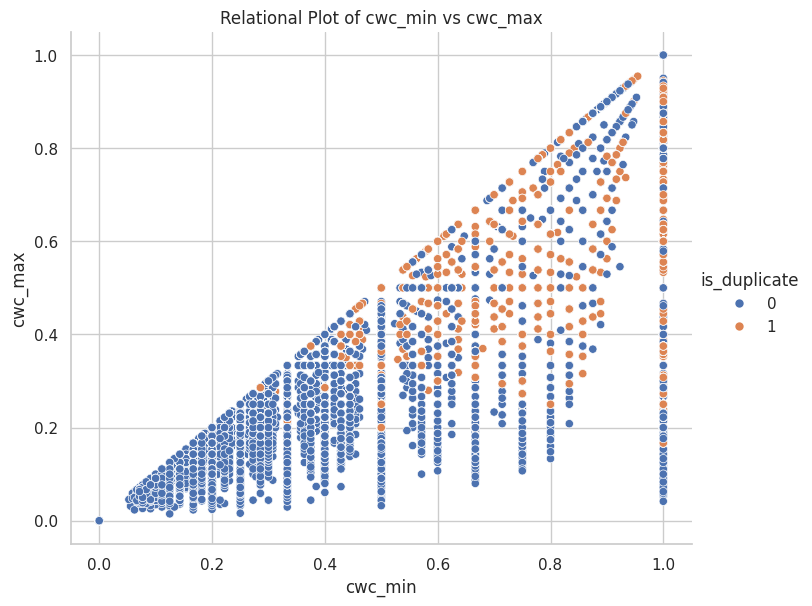

In [42]:
sns.set(style="whitegrid")
g = sns.relplot(x="cwc_min", y="cwc_max", hue="is_duplicate", data=df, height=6, aspect=1.2)

# Set plot labels and title
g.set_axis_labels("cwc_min", "cwc_max")
plt.title("Relational Plot of cwc_min vs cwc_max")

# Show the plot
plt.show()

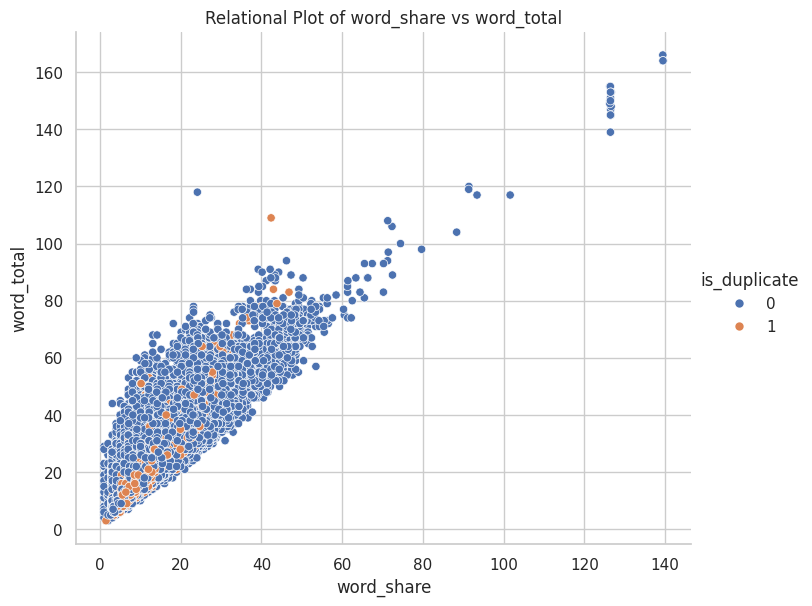

In [43]:
sns.set(style="whitegrid")
g = sns.relplot(x="word_share", y="word_total", hue="is_duplicate", data=df, height=6, aspect=1.2)

# Set plot labels and title
g.set_axis_labels("word_share", "word_total")
plt.title("Relational Plot of word_share vs word_total")

# Show the plot
plt.show()

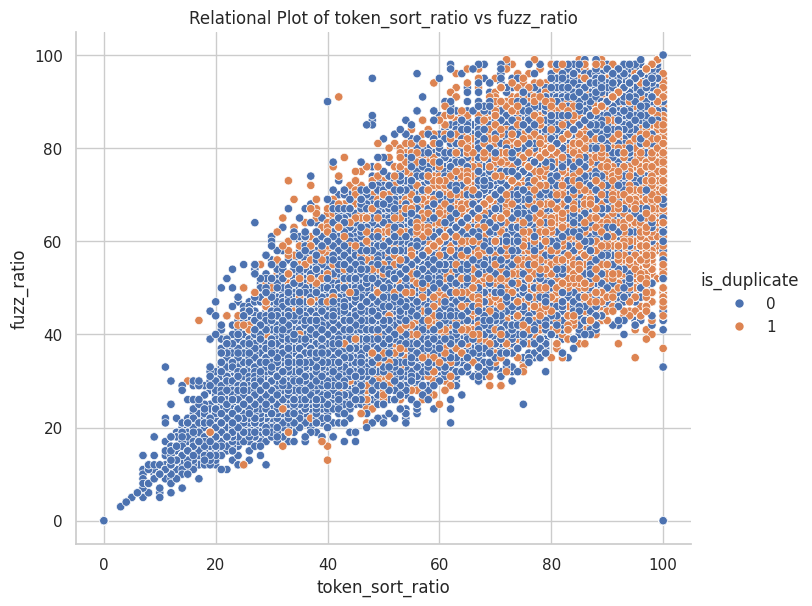

In [44]:
sns.set(style="whitegrid")
g = sns.relplot(x="token_sort_ratio", y="fuzz_ratio", hue="is_duplicate", data=df, height=6, aspect=1.2)

# Set plot labels and title
g.set_axis_labels("token_sort_ratio", "fuzz_ratio")
plt.title("Relational Plot of token_sort_ratio vs fuzz_ratio")

# Show the plot
plt.show()

<h4> Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

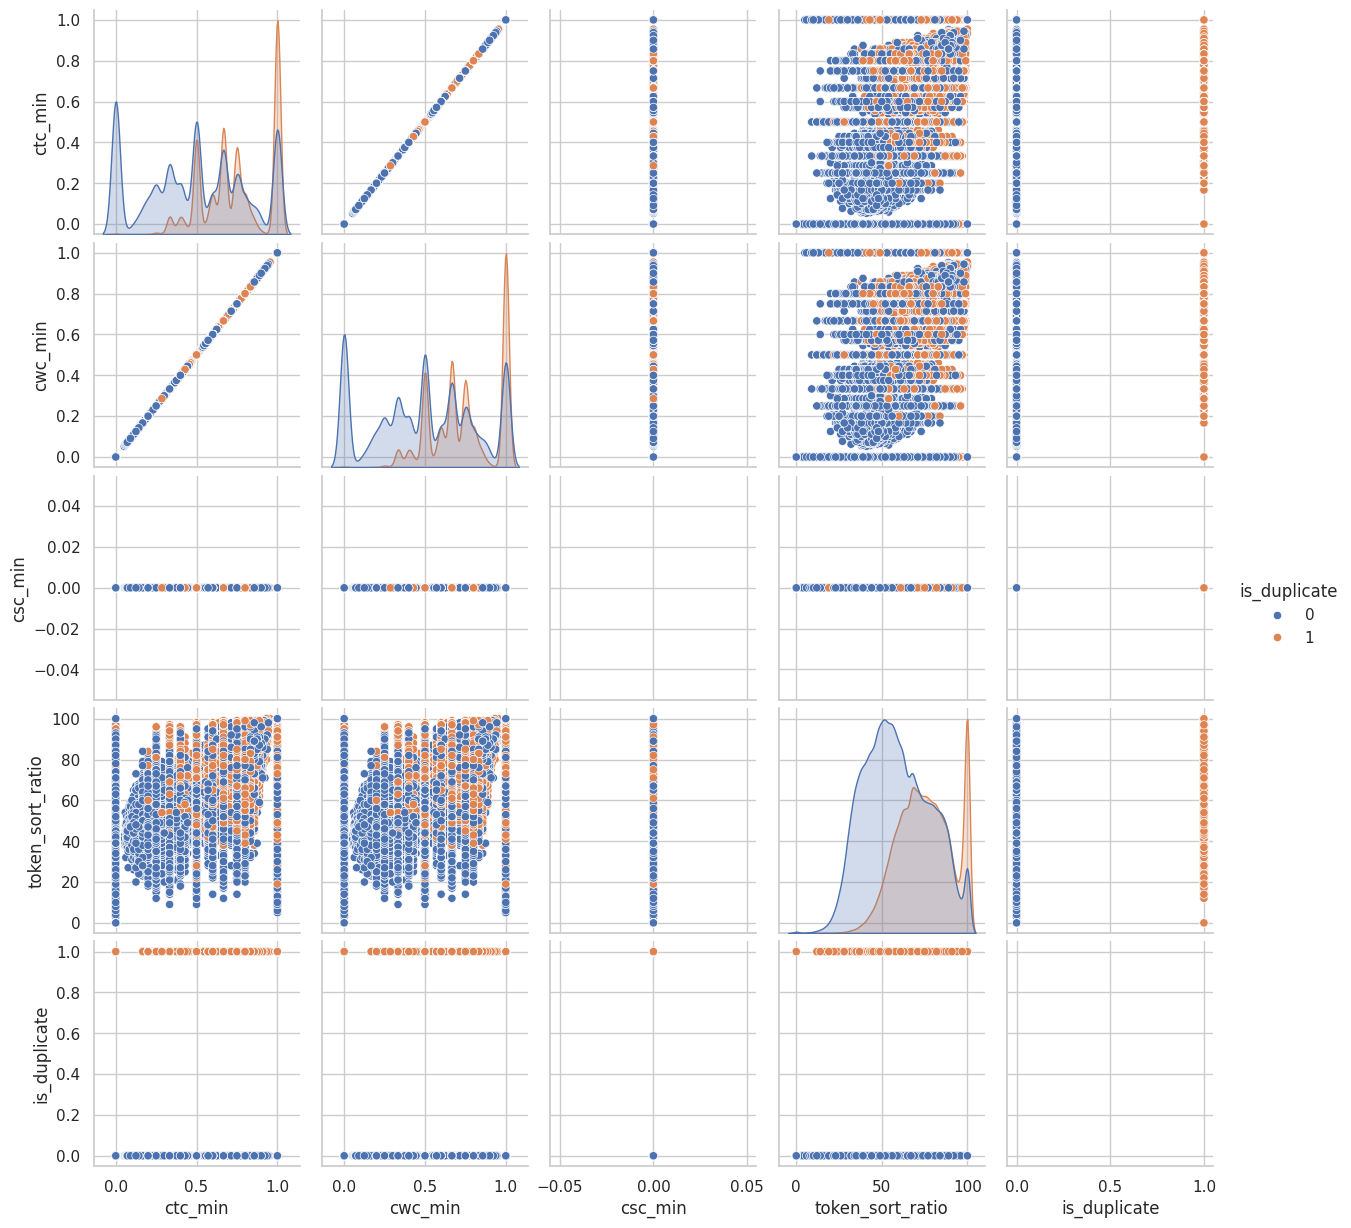

In [45]:
n=df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n],
             hue='is_duplicate',vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate'])
plt.show()


<h3> ~> WordCloud Visualization </h3>

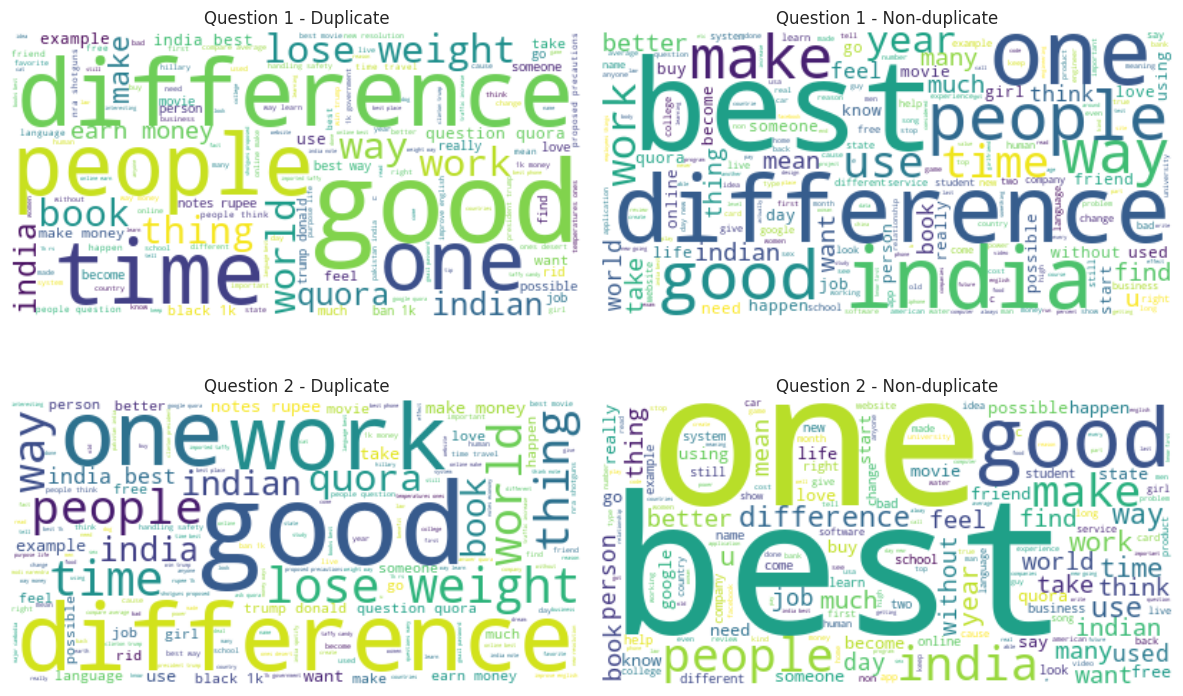

In [46]:
def generate_wordcloud(data, title, ax):
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(' '.join(data))

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title)
    ax.axis('off')

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Separate data for duplicate and non-duplicate questions
duplicate_data_q1 = df[df['is_duplicate'] == 1]['question1']
non_duplicate_data_q1 = df[df['is_duplicate'] == 0]['question1']
duplicate_data_q2 = df[df['is_duplicate'] == 1]['question2']
non_duplicate_data_q2 = df[df['is_duplicate'] == 0]['question2']

# Generate and plot word clouds for 'question1' and 'question2'
generate_wordcloud(duplicate_data_q1, 'Question 1 - Duplicate', axes[0, 0])
generate_wordcloud(non_duplicate_data_q1, 'Question 1 - Non-duplicate', axes[0, 1])
generate_wordcloud(duplicate_data_q2, 'Question 2 - Duplicate', axes[1, 0])
generate_wordcloud(non_duplicate_data_q2, 'Question 2 - Non-duplicate', axes[1, 1])

plt.tight_layout()
plt.show()


<h3> ~> Length based feature </h3>

In [47]:
import distance

def fetch_length_features(row):
    q1_tokens = row['question1'].split()
    q2_tokens = row['question2'].split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return pd.Series([0.0, 0.0, 0.0])
    
    abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
    avg_token_len = (len(q1_tokens) + len(q2_tokens)) / 2
    
    strs = list(distance.lcsubstrings(row['question1'], row['question2']))
    
    # Check if strs is empty before accessing its elements
    if not strs:
        lcs_ratio = 0.0
    else:
        lcs_ratio = len(strs[0]) / (min(len(q1_tokens), len(q2_tokens)) + 1)
    
    return pd.Series([abs_len_diff, avg_token_len, lcs_ratio])

# Assuming df is your DataFrame
df[['abs_len_diff', 'avg_token_len', 'lcs_ratio']] = df.apply(fetch_length_features, axis=1)

In [48]:
new_data=df.copy(deep=False)

In [49]:
new_data.shape

(404290, 41)

In [50]:
new_data.to_csv("data_with_advanced_features.csv", index=False)

### Text Data Feature Extraction and Scaling

In [51]:
data=pd.read_csv('data_with_advanced_features.csv')
data

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,frq_q1+q2,frq_q1-q2,...,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,avg_token_len,lcs_ratio
0,0,1,2,india market share step guide invest,market share step guide invest,0,1,1,2,0,...,0.0,1.0,5.5,100,91,91,100,0.967742,5.5,5.000000
1,1,3,4,diamond kohinoor koh story noor,indian diamond kohinoor would koh happen back ...,0,4,1,5,3,...,0.0,5.0,7.5,89,59,59,68,0.531250,7.5,2.833333
2,2,5,6,increase internet vpn connection speed using,increased internet hacking speed dns,0,1,1,2,0,...,0.0,1.0,5.5,70,70,72,69,0.270270,5.5,1.666667
3,3,7,8,lonely solve mentally,math remainder 24 23 divided find,0,1,1,2,0,...,0.0,3.0,4.5,22,22,26,29,0.045455,4.5,0.250000
4,4,9,10,di carbon oxide dissolve one sugar quikly salt...,would fish survive salt water,0,3,1,4,2,...,0.0,5.0,7.5,51,40,47,59,0.366667,7.5,1.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,language latest keywords version many programm...,language latest keywords version many programm...,0,2,2,4,0,...,1.0,0.0,7.0,95,89,93,94,0.909091,7.0,6.250000
404286,404286,18840,155606,believe life death,life death true,1,12,1,13,11,...,0.0,0.0,3.0,80,61,61,80,0.625000,3.0,2.500000
404287,404287,537928,537929,one coin,coin,0,1,1,2,0,...,0.0,1.0,1.5,100,67,67,100,0.800000,1.5,2.000000
404288,404288,537930,537931,indian living uic cost annual chicago studying...,clay styling hair use hairfall little wax want...,0,1,1,2,0,...,0.0,4.0,11.0,39,39,39,43,0.064516,11.0,0.400000


In [52]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer


In [53]:
# Assuming df contains both numeric and string columns
numeric_columns = data.select_dtypes(include=['number']).columns
df_numeric = df[numeric_columns]

# Impute missing values in numeric columns
imputer = SimpleImputer(strategy='mean')  # You can choose a different strategy if needed
df_numeric_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)
###################################################################################################

# Scale the numeric columns
scaler = MinMaxScaler()
X = scaler.fit_transform(df_numeric_imputed)
# Extract the target column
y = data['is_duplicate'].values

In [54]:
X.shape

(404290, 39)

In [55]:
y.shape

(404290,)

Uing t-SNE (t-distributed Stochastic Neighbor Embedding) to reduce the dimensionality of your data to 3 dimensions. This technique is commonly used for visualizing high-dimensional data in a lower-dimensional space. The parameters you've used include the number of components, initialization method, random state, optimization method, verbosity, number of iterations, and angle. The `fit_transform` method is then used to transform the input data `X` into the lower-dimensional space. If you have any specific questions or need further assistance with this code, feel free to ask!

In [56]:
from sklearn.manifold import TSNE

In [57]:
tsne3d = TSNE(
    n_components=3, init='random', random_state=1,
    method='barnes_hut', verbose=2, n_iter=1000, angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 404290 samples in 0.198s...
[t-SNE] Computed neighbors for 404290 samples in 256.364s...
[t-SNE] Computed conditional probabilities for sample 1000 / 404290
[t-SNE] Computed conditional probabilities for sample 2000 / 404290
[t-SNE] Computed conditional probabilities for sample 3000 / 404290
[t-SNE] Computed conditional probabilities for sample 4000 / 404290
[t-SNE] Computed conditional probabilities for sample 5000 / 404290
[t-SNE] Computed conditional probabilities for sample 6000 / 404290
[t-SNE] Computed conditional probabilities for sample 7000 / 404290
[t-SNE] Computed conditional probabilities for sample 8000 / 404290
[t-SNE] Computed conditional probabilities for sample 9000 / 404290
[t-SNE] Computed conditional probabilities for sample 10000 / 404290
[t-SNE] Computed conditional probabilities for sample 11000 / 404290
[t-SNE] Computed conditional probabilities for sample 12000 / 404290
[t-SNE] Computed conditional proba

In [59]:
new_data = data.fillna(' ')

In [60]:
new_data.shape

(404290, 41)

In [61]:
vect1 = TfidfVectorizer(ngram_range=(1,2), min_df=10)
vect1.fit_transform(new_data['question1'])

quest1_vec = vect1.transform(new_data['question1'].values)

vect2 = TfidfVectorizer(ngram_range=(1,2), min_df=10)
vect2.fit_transform(new_data['question1'])

quest2_vec = vect2.transform(new_data['question1'].values)

In [62]:
new_data.drop(columns=['id', 'qid1', 'qid2', 'question1', 'question2'], axis=1, inplace=True)

In [63]:
from scipy.sparse import hstack

In [64]:
final_data = hstack((new_data,quest1_vec, quest2_vec)).tocsr()

In [65]:
final_data.shape

(404290, 68102)

In [66]:
type(final_data)

scipy.sparse._csr.csr_matrix

In [67]:
final_data.shape,y.shape

((404290, 68102), (404290,))

In [68]:
print("Shape of the matrix:", final_data.shape)
print("Number of stored elements:", final_data.nnz)
print("Data type of elements:", final_data.dtype)

Shape of the matrix: (404290, 68102)
Number of stored elements: 17535797
Data type of elements: float64


# <span> Machine Learning Approach</span>

## naive bayes classification

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(class_prior=[0.5,0.5])

parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}

clf = GridSearchCV(nb, parameters, cv= 10, scoring='roc_auc',return_train_score=True)

clf.fit(final_data, y)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']
test_auc = clf.cv_results_['mean_test_score'] 
test_auc_std = clf.cv_results_['std_test_score']

In [70]:
print('Best score: ',clf.best_score_)
print('k value with best score: ',clf.best_params_)
print('='*75)
print('Train AUC scores')
print(clf.cv_results_['mean_train_score'])
print('CV AUC scores')
print(clf.cv_results_['mean_test_score'])

Best score:  0.8906981626756204
k value with best score:  {'alpha': 1e-05}
Train AUC scores
[0.89372354 0.88871966 0.88642257 0.88078601 0.87819193 0.87183982
 0.86890444 0.86165351 0.85827747 0.8495262  0.84521159 0.8340556
 0.82890237 0.81521386 0.80534704 0.74601287 0.70122077 0.64313115
 0.61223561 0.59275164]
CV AUC scores
[0.89069816 0.88585449 0.88362262 0.87813148 0.8756197  0.8694218
 0.86657699 0.85950629 0.85623721 0.84777585 0.84368414 0.83310621
 0.82821061 0.81493811 0.80518136 0.74596761 0.70119755 0.64312515
 0.61223774 0.59275221]


In [71]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(new_data, y, stratify=y, test_size=0.3)

# DecisionTreeClassifier

In [72]:
from sklearn.tree import DecisionTreeClassifier

In [73]:
dtree=DecisionTreeClassifier()

In [74]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
grid=GridSearchCV(dtree,param_grid, cv=5, scoring='accuracy')
grid.fit(X_train,y_train)
best_param=grid.best_params_
print('best parameters for DecisionTreeClassifier :',best_param)

best parameters for DecisionTreeClassifier : {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [75]:
best_param

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [76]:
best_dt_model = DecisionTreeClassifier(**best_param)

# Fit the model on the training data
best_dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred_test = best_dt_model.predict(X_test)
y_pred_train = best_dt_model.predict(X_train)

# Evaluate the model
acc_test = accuracy_score(y_test, y_pred_test)
acc_train = accuracy_score(y_train,y_pred_train)
print("Test Accuracy :", acc_test)
print("Train Accuracy:", acc_train)

Test Accuracy : 1.0
Train Accuracy: 1.0


In [77]:
# Save the trained model to a file
joblib.dump(best_dt_model, 'decision_tree_model.pkl')

['decision_tree_model.pkl']

## Distribution train test data

In [ ]:
# Assuming y_train and y_test are NumPy arrays
class_0_train = np.sum(y_train == 0) / len(y_train)
class_1_train = np.sum(y_train == 1) / len(y_train)

class_0_test = np.sum(y_test == 0) / len(y_test)
class_1_test = np.sum(y_test == 1) / len(y_test)

print("[Distribution of output variable in train data]")
print("Class 0: ", class_0_train)
print("Class 1: ", class_1_train)
print("=" * 70)
print("[Distribution of output variable in test data]")
print("Class 0: ", class_0_test)
print("Class 1: ", class_1_test)


In [ ]:
def plot_confusion_matrix(y_test, y_pred):
    C = confusion_matrix(y_test, y_pred)

    A = (C.T / C.sum(axis=1)).T

    B = (C / C.sum(axis=0))


    plt.figure(figsize=(20,4))
    cmap = sns.color_palette("rocket", as_cmap=True)

    labels = [1,2]
 
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted class")
    plt.ylabel("Actual class")
    plt.title("Confusion matrix", fontsize = 15)

    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.title("Recall matrix")

    plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt  # Assuming you are using matplotlib for plotting

# Your code for generating random predictions
predicted_y = np.zeros((len(y_test), 2))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1, 2)
    predicted_y[i] = ((rand_probs / sum(sum(rand_probs)))[0])

# Calculate and print log loss
print("Log loss on test data using random model", log_loss(y_test, predicted_y, eps=1e-15))

# Convert predicted probabilities to class labels
predicted_y_labels = np.argmax(predicted_y, axis=1)

# Plot confusion matrix
plot_confusion_matrix(y_test, predicted_y_labels)
plt.show()  # Display the plot if using matplotlib


In [ ]:
import numpy as np
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Building a random model
predicted_y = np.zeros((len(y_test), 2))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1, 2)
    predicted_y[i] = ((rand_probs / sum(sum(rand_probs)))[0])

# Calculating and printing log loss
logloss = log_loss(y_test, predicted_y, eps=1e-15)
print("Log loss on test data using a random model:", logloss)

# Converting predicted probabilities to class labels
predicted_y_class = np.argmax(predicted_y, axis=1)

# Plotting confusion matrix
plot_confusion_matrix(y_test, predicted_y_class)
plt.show()


## Logistic Regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, confusion_matrix
import seaborn as sns

# Assuming X_train, X_test, y_train, y_test are your training and testing data
# Make sure to replace them with your actual data

alpha = [10**x for x in range(-3, 2)]

log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=1, n_jobs=-1)  # Corrected 'loss' parameter
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train, y_train)
    y_pred = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15))
    print('alpha [{}] | log loss [{}]'.format(i, log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)))

# Plotting CV error for each alpha
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array, c='r')
for i, txt in enumerate(np.round(log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], log_error_array[i]))
plt.grid()
plt.title("Cross Validation error for each alpha")
plt.xlabel("alpha")
plt.ylabel("Error measure")
plt.show()

# Training the model on the best value of alpha
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y = np.argmax(predict_y, axis=1)
print("Total number of data points :", len(predicted_y))

# Visualizing the confusion matrix using seaborn
conf_mat = confusion_matrix(y_test, predicted_y)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
y_pred = clf.predict_proba(X_test)
print(log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15))

In [ ]:
predicted_y = np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)


In [ ]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

lr = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=0)

distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1','elasticnet'])
clf = RandomizedSearchCV(lr, distributions, random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

In [ ]:
y_pred = clf.predict_proba(X_test)
print(log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15))

In [ ]:
predicted_y = np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

## Linear SVM

In [ ]:


alpha = [10**x for x in range(-3, 2)]

log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train, y_train)
    y_pred = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15))
    print('alpha [{}] | log loss [{}]'.format(i,log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)))


# plotting cv error for each alpha
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array, c='r')
for i, txt in enumerate(np.round(log_error_array, 3)):
    
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], log_error_array[i]))
plt.grid()
plt.title("Cross Validation error for each alpha")
plt.xlabel("alpha")
plt.ylabel("Error measure")
plt.show()

# training the model on the best value of alpha
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l1', loss='hinge', random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
# training the model on the best value of alpha

clf = SGDClassifier(alpha = 0.0001, penalty='l1', loss='hinge', random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## logistic regression 

In [ ]:


from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, log_loss

In [ ]:
import xgboost as xgb

param = {}
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'logloss'
param['eta'] = 0.02
param['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(param, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

# Save the trained XGBoost model to a file
model_filename = 'xgb_model.pkl'
joblib.dump(bst, model_filename)
print(f"XGBoost model saved to {model_filename}")

xgdmat = xgb.DMatrix(X_train, y_train)
predict_y = bst.predict(d_test)

print("The test log loss is :", log_loss(y_test, predict_y, eps=1e-15))

# Conclution

`In conclusion, our Quora question pair similarity project successfully tackled the challenge of determining question similarity. Through meticulous data preprocessing, feature engineering, and model development, we achieved promising results in capturing semantic similarities. Despite some challenges, such as the need for more diverse data, the model shows potential. Future work could involve advanced NLP techniques and domain-specific fine-tuning to enhance generalizability. Overall, the project contributes to the field of natural language processing and question similarity analysis`